In [1]:
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [3]:
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load('tf_flowers', as_supervised=True,with_info=True)
dataset_size = info.splits['train'].num_examples #3670
class_names = info.features['label'].names #['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = info.features['label'].num_classes # 5

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\yche1\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [30]:
dataset

{Split('train'): <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>}

In [38]:
test_set, valid_set, train_set = tfds.load('tf_flowers', split=["train[:10%]","train[10%:25%]","train[25%:]"],as_supervised=True)

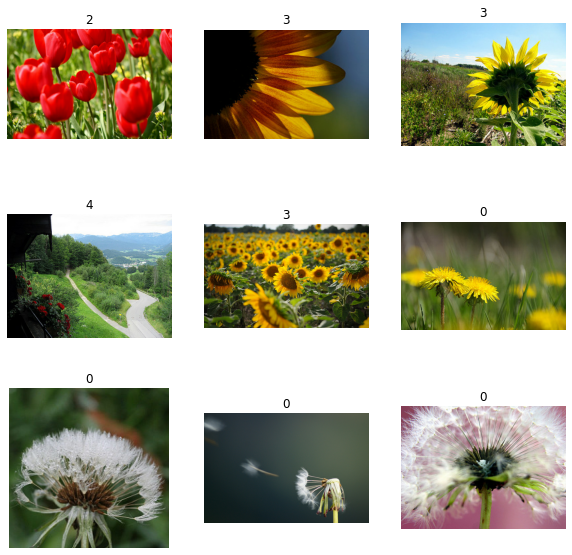

In [32]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(test_set.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [28]:
def preprocess(image, label):
    #改变图像大小
    resized_image=tf.image.resize(image,[224,224])
    final_image=keras.applications.xception.preprocess_input(resized_image)
    return final_image,label

In [39]:
batch_size=32
train_set=train_set.shuffle(1000)
train_set=train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set=valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set=test_set.map(preprocess).batch(batch_size).prefetch(1)
#batch将数据分为32一组，perfetch允许提前加载

In [43]:
base_model=keras.applications.xception.Xception(weights='imagenet',include_top=False)
avg=keras.layers.GlobalAveragePooling2D()(base_model.output)
output=keras.layers.Dense(n_classes,activation='softmax')(avg)
model=keras.Model(inputs=base_model.input,outputs=output)

In [49]:
for layer in base_model.layers:
    layer.trainable=False #使其在推断模式下运行，这样，即使在我们解冻基础模型以进行微调后，batchnorm 统计信息也不会更新

In [51]:
optimizer=keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)

In [53]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
#loss是损失函数定义方法
#optimizer是处理器
#metrics是评估模型的指标

In [54]:
history=model.fit(train_set,epochs=5,validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 168s 2s/step - loss: 1.5104 - accuracy: 0.7860 - val_loss: 1.2339 - val_accuracy: 0.8512
Epoch 2/5
86/86 [==============================] - 163s 2s/step - loss: 0.4856 - accuracy: 0.9095 - val_loss: 0.8903 - val_accuracy: 0.8675
Epoch 3/5
86/86 [==============================] - 160s 2s/step - loss: 0.2139 - accuracy: 0.9448 - val_loss: 0.8373 - val_accuracy: 0.8566
Epoch 4/5
86/86 [==============================] - 161s 2s/step - loss: 0.1297 - accuracy: 0.9637 - val_loss: 0.7221 - val_accuracy: 0.8711
Epoch 5/5
86/86 [==============================] - 161s 2s/step - loss: 0.0848 - accuracy: 0.9746 - val_loss: 0.7185 - val_accuracy: 0.8675


In [55]:
history